# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#import gensim
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [7]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [9]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [10]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [11]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [16]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [18]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [19]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [20]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [21]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [23]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [25]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [27]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [28]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:00<00:00, 1457.82it/s]


In [31]:
final['Cleaned Text'] = preprocessed_reviews

In [32]:
sample1 = pd.DataFrame()

In [33]:
sample1['Cleaned Text'] =preprocessed_reviews

In [34]:
sample1.tail(3)

,Cleaned Text
87770,trader joe product good quality buy straight t...
87771,coffee supposedly premium tastes watery thin n...
87772,purchased product local store ny kids love qui...


In [35]:
k1 = []

In [36]:
sample1.shape

(87773, 1)

In [37]:
for i in range(0,87773):
    k1.append(len(preprocessed_reviews[i]))

In [38]:
sample1['Length'] = k1

In [39]:
sample1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Splitting the Data with feature engineering

In [41]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(sample1,final['Score'].values,test_size=0.3,shuffle=False)

In [42]:
y_train1.shape

(61441,)

In [43]:
X_train1.shape

(61441, 2)

In [44]:
X_test1.shape

(26332, 2)

In [45]:
type(y_test1)

numpy.ndarray

In [46]:
type(X_test1)

pandas.core.frame.DataFrame

In [47]:
X_train1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [48]:
X_test1.head(3)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181


In [49]:
X_trainbow = pd.DataFrame()

In [50]:
X_trainbow['Cleaned Text'] = X_train1['Cleaned Text'] 

In [51]:
X_trainbow.head(3)

,Cleaned Text
0,dogs loves chicken product china wont buying a...
1,dogs love saw pet store tag attached regarding...
2,infestation fruitflies literally everywhere fl...


In [52]:
X_testbow = pd.DataFrame()

In [53]:
X_testbow['Cleaned Text'] = X_test1['Cleaned Text']

In [54]:
X_testbow.head(3)

,Cleaned Text
61441,used treat training reward dog loves easy brea...
61442,much fun watching puppies asking chicken treat...
61443,little shih tzu absolutely loves cesar softies...


# BAG OF WORDS WITH FEATURE ENGINEERING 

In [55]:
X_trainbow.shape

(61441, 1)

In [56]:
X_testbow.shape

(26332, 1)

In [57]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b1 = count_vect.transform(X_testbow['Cleaned Text'])

In [58]:
print("the type of count vectorizer :",type(a1))
print("the shape of out text BOW vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (61441, 46008)
the number of unique words : 46008


# ADDING LENGTH OF REVIEWS AS ONE FEATURE 

In [59]:
a1 = preprocessing.normalize(a1)

In [60]:
from scipy import sparse

In [61]:
from scipy.sparse import csr_matrix

In [62]:
a2 = sparse.csr_matrix(X_train1['Length'].values)

In [63]:
a2 = preprocessing.normalize(a2)

In [64]:
a1

<61441x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 2002037 stored elements in Compressed Sparse Row format>

In [65]:
a2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [66]:
a3 = sparse.hstack([a1, a2.T])

In [67]:
a3.shape

(61441, 46009)

In [68]:
b1 = preprocessing.normalize(b1)

In [69]:
b2 = sparse.csr_matrix(X_test1['Length'].values)

In [70]:
b2 = preprocessing.normalize(b2)

In [71]:
b1

<26332x46008 sparse matrix of type '<class 'numpy.float64'>'
	with 888781 stored elements in Compressed Sparse Row format>

In [72]:
b2.T

<26332x1 sparse matrix of type '<class 'numpy.float64'>'
	with 26286 stored elements in Compressed Sparse Column format>

In [73]:
b3 = sparse.hstack([b1, b2.T])

In [74]:
a3.shape

(61441, 46009)

In [75]:
b3.shape

(26332, 46009)

In [76]:
y_test1.shape

(26332,)

In [77]:
y_train1.shape

(61441,)

# Decision Tree for BOW with Feature Engineering

# Logistic Regression for BOW with Feature Engineering

In [78]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [79]:
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [76]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model_bow = GridSearchCV(DecisionTreeClassifier(max_features="log2",class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model_bow.fit(a3, y_train1)
print(model_bow.best_estimator_)
print(model_bow.score(b3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=1000, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.6838225922011263


In [77]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model_bow1 = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model_bow1.fit(a3, y_train1)
print(model_bow1.best_estimator_)
print(model_bow1.score(b3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8006141680733525


# Observations for Decision Tree Classifier (BOW) 

1) When all features are taken in to consideration, we observe that the AUC is more. However it takes lot of time to compute

2) When log(n) features were takeen the score is lower. But the computation time is faster.

3) There is almost 17% increase in AUC value when i chose all the features.

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Running the Model with Optimal max_depth and splits

In [5]:
from sklearn.metrics import roc_auc_score

In [92]:
alph_depth = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50,100,100,100,100,500,500,500,500,1000,1000,1000,1000]
alph_split = [5,10,100,500]*7

In [83]:
model_bow1.cv_results_

{'mean_fit_time': array([  1.01787515,   1.11951375,   1.02847285,   1.038726  ,
          1.73348079,   1.73733039,   1.6189199 ,   1.56021628,
          3.12114091,   3.06207037,   2.75605822,   2.57234359,
         14.86219864,  14.33729925,  11.15002289,   8.21201043,
         48.90694871,  46.04256434,  38.4334065 ,  27.82593322,
         71.29822412,  69.97879577,  60.19951959,  46.83349395,
         57.44790826,  56.36955051,  58.01324306, 147.42662067]),
 'std_fit_time': array([1.86974580e-02, 4.46724717e-02, 5.16100208e-02, 3.69513760e-02,
        6.27996366e-02, 6.13830474e-02, 3.14645684e-02, 2.08351998e-02,
        7.28540668e-02, 6.73345018e-02, 4.12170461e-02, 4.99461708e-02,
        2.25300235e-01, 2.72376790e-01, 4.07473522e-01, 1.74778685e-01,
        1.79941406e+00, 2.36646278e+00, 9.96946429e-01, 5.57440178e-01,
        1.89855306e+00, 2.28714628e+00, 2.35629371e+00, 3.63952011e+00,
        1.59679876e+01, 1.72424733e+01, 1.45248307e+00, 2.54985619e+02]),
 'mean_scor

In [78]:
#train_auc= model.cv_results_['mean_train_score']
#cv_auc= model.cv_results_['mean_test_score']

In [84]:
train_auc1= model_bow1.cv_results_['mean_train_score']
cv_auc1= model_bow1.cv_results_['mean_test_score']

In [85]:
train_auc1

array([0.62738578, 0.62738578, 0.62738578, 0.62738578, 0.74043808,
       0.74041863, 0.73984155, 0.7388187 , 0.82260081, 0.82168606,
       0.81323469, 0.80740418, 0.97938132, 0.97358033, 0.94461097,
       0.91159668, 0.99126514, 0.98742239, 0.96367886, 0.92897549,
       0.99988578, 0.9989496 , 0.98414218, 0.95194815, 0.99988166,
       0.99896188, 0.98373419, 0.95149651])

In [86]:
cv_auc1

array([0.62635852, 0.62635852, 0.62635852, 0.62635852, 0.72853542,
       0.72841512, 0.72839481, 0.7293944 , 0.76819878, 0.76840359,
       0.77393852, 0.77758391, 0.71170473, 0.71795459, 0.76071125,
       0.79462643, 0.71099308, 0.71944937, 0.75832361, 0.78513332,
       0.69192081, 0.70032606, 0.73055995, 0.75580942, 0.69284841,
       0.69805486, 0.73269249, 0.75694787])

In [82]:
#train_auc

array([0.5       , 0.5       , 0.76796783, 0.96421071, 0.99985648,
       0.99999725, 0.99999725])

In [83]:
#cv_auc

array([0.5       , 0.5       , 0.76602852, 0.94476225, 0.90027524,
       0.8802149 , 0.85237726])

In [87]:
import math
from math import log

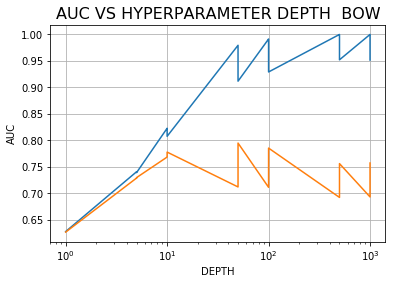



 Depth Values :
 [1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10, 50, 50, 50, 50, 100, 100, 100, 100, 500, 500, 500, 500, 1000, 1000, 1000, 1000]

 Train AUC for each alpha value is :
  [0.62739 0.62739 0.62739 0.62739 0.74044 0.74042 0.73984 0.73882 0.8226
 0.82169 0.81323 0.8074  0.97938 0.97358 0.94461 0.9116  0.99127 0.98742
 0.96368 0.92898 0.99989 0.99895 0.98414 0.95195 0.99988 0.99896 0.98373
 0.9515 ]

 CV AUC for each alpha value is :
  [0.62636 0.62636 0.62636 0.62636 0.72854 0.72842 0.72839 0.72939 0.7682
 0.7684  0.77394 0.77758 0.7117  0.71795 0.76071 0.79463 0.71099 0.71945
 0.75832 0.78513 0.69192 0.70033 0.73056 0.75581 0.69285 0.69805 0.73269
 0.75695]


In [101]:
# Firstly I am plotting depth vs AUC and then split vs AUC
plt.plot(alph_depth,train_auc1)
plt.plot(alph_depth,cv_auc1)
plt.xlabel('DEPTH',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER DEPTH  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Depth Values :\n", alph_depth)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc1,5))

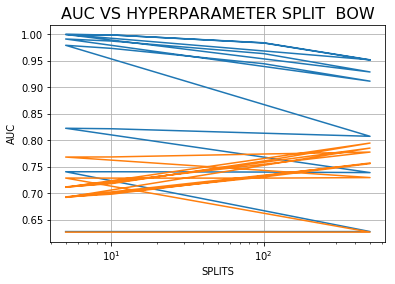



 Split Values :
 [5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500]

 Train AUC for each alpha value is :
  [0.62739 0.62739 0.62739 0.62739 0.74044 0.74042 0.73984 0.73882 0.8226
 0.82169 0.81323 0.8074  0.97938 0.97358 0.94461 0.9116  0.99127 0.98742
 0.96368 0.92898 0.99989 0.99895 0.98414 0.95195 0.99988 0.99896 0.98373
 0.9515 ]

 CV AUC for each alpha value is :
  [0.62636 0.62636 0.62636 0.62636 0.72854 0.72842 0.72839 0.72939 0.7682
 0.7684  0.77394 0.77758 0.7117  0.71795 0.76071 0.79463 0.71099 0.71945
 0.75832 0.78513 0.69192 0.70033 0.73056 0.75581 0.69285 0.69805 0.73269
 0.75695]


In [100]:
plt.plot(alph_split,train_auc1)
plt.plot(alph_split,cv_auc1)
plt.xlabel('SPLITS',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER SPLIT  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Split Values :\n", alph_split)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc1,5))

In [102]:
max(cv_auc1)

0.7946264342396073

# Observations

1) We have found that the hyperparmeters max_depth should be 50 and min_splits should be 500 for having maximum AUC for CV 


In [87]:
optimalalpha2_bow = 1
auc_bow = max(cv_auc)
auc_bow1 = max(cv_auc1)

In [88]:
from IPython.display import HTML, display
import tabulate
table = [["Vectorizer","Model","Regularisation","Hyperparameter","AUC"],
         ["BOW", "Logistic Regression ", "L1 " ,optimalalpha2_bow, np.round(auc_bow,4) ],
         ["BOW", "Logistic Regression ", "L2 " ,optimalalpha2_bow, np.round(auc_bow1,4)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Vectorizer,Model,Regularisation,Hyperparameter,AUC
BOW,Logistic Regression,L1,1,0.9448
BOW,Logistic Regression,L2,1,0.9439


In [90]:
# after you found the best hyper parameter, you need to train your model with it, 
#and find the AUC on test data and plot the ROC curve on both train and test. 
# Along with plotting ROC curve, you need to print the confusion matrix with predicted 
#and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps. 

# Training the model with the best hyper parameter 

In [80]:
om_bow = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50 , min_samples_split = 500 )

In [81]:
#om_bow = MultinomialNB(alpha = optimalalpha2_bow)
# fitting the model and predicting the responses
om_bow.fit(a3, y_train1)
ompredictions_bow  = om_bow.predict(b3)

In [82]:
len(ompredictions_bow)

26332

In [83]:
len(y_test1)

26332

In [84]:
probs = om_bow.predict_proba(b3)

In [85]:
probs1 = om_bow.predict_proba(a3)

In [86]:
len(probs1)

61441

In [87]:
len(probs)

26332

In [88]:
probs = probs[:, 1]

In [89]:
probs1 = probs1[:, -1]

# Graphviz

In [122]:
from sklearn.datasets import load_iris
from sklearn import tree

[Text(249.493,222.24,'X[27139] <= 0.079\nentropy = 0.5\nsamples = 61441\nvalue = [30720.5, 30720.5]'),
 Text(185.169,217.839,'X[17569] <= 0.059\nentropy = 0.446\nsamples = 29196\nvalue = [8019.855, 15824.13]'),
 Text(173.329,213.438,'X[3744] <= 0.043\nentropy = 0.476\nsamples = 21797\nvalue = [7386.541, 11553.11]'),
 Text(161.517,209.037,'X[23595] <= 0.148\nentropy = 0.487\nsamples = 18970\nvalue = [7147.855, 9920.631]'),
 Text(149.76,204.636,'X[17183] <= 0.188\nentropy = 0.495\nsamples = 16033\nvalue = [6762.775, 8250.188]'),
 Text(138.114,200.236,'X[23609] <= 0.099\nentropy = 0.499\nsamples = 13480\nvalue = [6336.322, 6815.243]'),
 Text(126.691,195.835,'X[10560] <= 0.035\nentropy = 0.5\nsamples = 12416\nvalue = [6256.76, 6198.911]'),
 Text(115.714,191.434,'X[11440] <= 0.06\nentropy = 0.499\nsamples = 11357\nvalue = [6170.833, 5586.732]'),
 Text(113.34,187.033,'X[13900] <= 0.092\nentropy = 0.5\nsamples = 11174\nvalue = [5750.745, 5556.479]'),
 Text(103.252,182.633,'X[14617] <= 0.05\ne

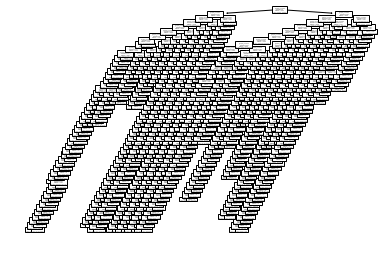

In [91]:
tree.plot_tree(om_bow.fit(a3, y_train1))

In [92]:
# I am not able to make sense of the tree . Hence I am exporting 

In [95]:
a3

<61441x46009 sparse matrix of type '<class 'numpy.float64'>'
	with 2063308 stored elements in COOrdinate format>

In [119]:
from sklearn.tree import export_graphviz
target = ['negative','positive']
export_graphviz(om_bow,out_file='bow_dt.dot.',class_names=target,rounded = True, proportion = False,max_depth=3,feature_names=features)

In [121]:
from graphviz import Source
from sklearn import tree

# FEATURE IMPORTANCE  FOR BOW 

In [97]:
om_bow.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')>

In [98]:
count_vect.get_params

<bound method BaseEstimator.get_params of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)>

In [112]:
features = count_vect.get_feature_names()

In [118]:
#features=np.argsort(features)[::-1]

In [114]:
feat_importances = om_bow.feature_importances_

In [115]:
len(features),len(feat_importances)
features.append('zzzzzzzzzza')

In [116]:
len(features)

46009

In [117]:
cf = pd.DataFrame({'Word' : features, 'Coefficient' : feat_importances})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 20 IMPORTANT FEATURES  *****')
print('\n')
print(cf_new.head(20))
#print('\n')
#print('***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****')
#print('\n')
#print(cf_new.tail(10))

***** Top 20 IMPORTANT FEATURES  *****


               Word  Coefficient
27139           not     0.140460
17569         great     0.089926
10560     delicious     0.040452
3744           best     0.040385
23595          love     0.029933
29622       perfect     0.024847
17183          good     0.024308
23609         loves     0.024093
11440  disappointed     0.021146
26852          nice     0.016022
13900     excellent     0.014375
14617      favorite     0.013908
18895        highly     0.013534
45177     wonderful     0.012340
2903            bad     0.012234
38261         stale     0.010604
41032       thought     0.009971
25745         money     0.009113
12625          easy     0.009022
2768          awful     0.007347


# Observations :
1) We have found that not  and great are the top 2 words that are having the highest influence.

# PERFORMANCE MEASURMENTS  FOR BOW ( DECISION TREE)

In [125]:
precision_bow = precision_score(y_test1, ompredictions_bow, pos_label = 1) 
recall_bow = recall_score(y_test1, ompredictions_bow, pos_label = 1) 
f1score_bow = f1_score(y_test1, ompredictions_bow, pos_label = 1) 

In [126]:
print('\nThe Test Precision for optimal depth and split values for Decision Tree (BOW)   is %f' % (precision_bow))
print('\nThe Test Recall for optimal depth and split values for Decision Tree (BOW)  is %f' % (recall_bow))
print('\nThe Test F1-Scorefor optimal depth and split values for Decision Tree (BOW)  is %f' %  (f1score_bow))


The Test Precision for optimal depth and split values for Decision Tree (BOW)   is 0.939356

The Test Recall for optimal depth and split values for Decision Tree (BOW)  is 0.693359

The Test F1-Scorefor optimal depth and split values for Decision Tree (BOW)  is 0.797826


# CONFUSION MATRIX 

In [132]:
# Reference Links 
# https://datatofish.com/confusion-matrix-python/

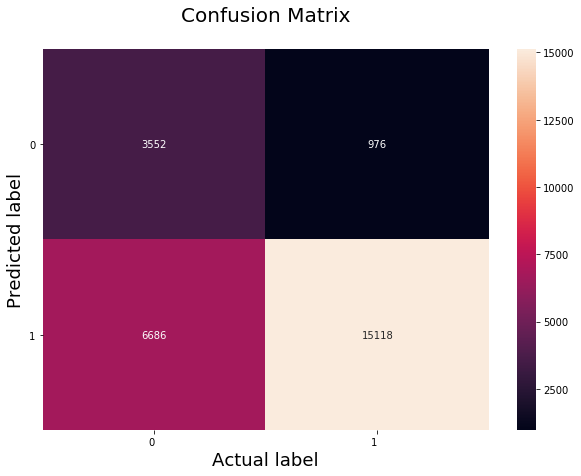

In [127]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_bow), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [128]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_bow).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)

In [129]:
print("TPR of the Decision Tree  (BOW)   is :  %f" % (TPR))
print("FPR of the Decision Tree  (BOW)   is :  %f" % (FPR))
print("TNR of the Decision Tree (BOW)   is :  %f" % (TNR))
print("FNR of the Decision Tree  (BOW)  is :  %f" % (FNR))

TPR of the Decision Tree  (BOW)   is :  0.939356
FPR of the Decision Tree  (BOW)   is :  0.653057
TNR of the Decision Tree (BOW)   is :  0.346943
FNR of the Decision Tree  (BOW)  is :  0.060644


# PLOTTING THE ROC CURVE  (BOW) ---- > FOR BOTH TRAIN AND TEST DATA 

In [130]:
len(y_train1)

61441

In [131]:
len(probs1)

61441

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

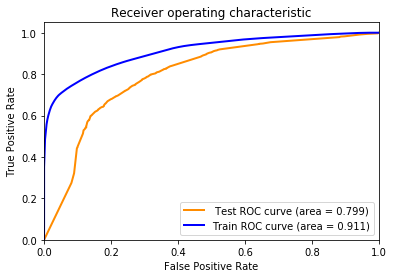

In [133]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 
1) We observe that AUC for train data is 0.91 even though the test data is 0.79. This implied that the model is overfitted. 

# TFIDF WITH FEATURE ENGINEERING 

In [134]:
tf_idf_vect = TfidfVectorizer(min_df=10)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (61441, 9723)
the number of unique words : 9723


In [135]:
c1 = preprocessing.normalize(c1)

In [136]:
c2 = sparse.csr_matrix(X_train1['Length'].values)
c2 = preprocessing.normalize(c2)

In [137]:
c1

<61441x9723 sparse matrix of type '<class 'numpy.float64'>'
	with 1925265 stored elements in Compressed Sparse Row format>

In [138]:
c2.T

<61441x1 sparse matrix of type '<class 'numpy.float64'>'
	with 61271 stored elements in Compressed Sparse Column format>

In [139]:
c3 = sparse.hstack([c1, c2.T])

In [140]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['Length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

# Decision Tree  - TFIDF

In [142]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model_tfidf = GridSearchCV(DecisionTreeClassifier(max_features="log2",class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model_tfidf.fit(c3, y_train1)
print(model_tfidf.best_estimator_)
print(model_tfidf.score(d3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.698775066112614


In [144]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model1_tfidf = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model1_tfidf.fit(c3, y_train1)
print(model1_tfidf.best_estimator_)
print(model1_tfidf.score(d3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7890400242231952


# Observations :

1) We found that the accuracy has enhanced when we used  all features . However computation time is more in this case.

# OPTIMAL ALPHA FOR TFIDF - THROUGH PLOTTING APPROACH 

In [182]:
alph_depth = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50,100,100,100,100,500,500,500,500,1000,1000,1000,1000]
alph_split = [5,10,100,500]*7

In [183]:
model1_tfidf.cv_results_

{'mean_fit_time': array([ 0.19246554,  0.195573  ,  0.20659676,  0.19630585,  0.87291446,
         0.85693283,  0.84818764,  0.83197412,  2.28739405,  2.19863219,
         1.8935554 ,  1.78212557, 13.81681061, 12.98860955, 10.56166449,
         7.01649137, 17.25311985, 16.61338453, 14.23996224,  8.92628307,
        24.87175694, 23.92781   , 21.08874831, 15.29480433, 23.11316381,
        22.61035819, 19.76628156, 15.70002403]),
 'std_fit_time': array([0.0057352 , 0.01443049, 0.00586341, 0.01227734, 0.03220714,
        0.0185391 , 0.01418578, 0.02134509, 0.04734477, 0.05749157,
        0.02101704, 0.06127148, 0.4814207 , 0.20046402, 0.22480554,
        0.216491  , 0.38337132, 0.47797433, 0.432881  , 0.45170812,
        0.62076266, 0.95960972, 1.03346876, 0.99033401, 0.64358931,
        0.78540116, 0.56460919, 1.57292037]),
 'mean_score_time': array([0.01374974, 0.01396151, 0.00751915, 0.01257119, 0.01176481,
        0.01231503, 0.01176686, 0.00844193, 0.01418328, 0.01196971,
        0.00

In [185]:
train_auc_tfidf = model1_tfidf.cv_results_['mean_train_score']
cv_auc_tfidf = model1_tfidf.cv_results_['mean_test_score']

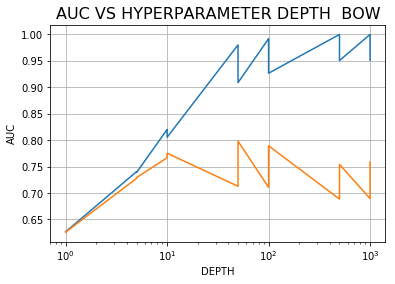



 Depth Values :
 [1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10, 50, 50, 50, 50, 100, 100, 100, 100, 500, 500, 500, 500, 1000, 1000, 1000, 1000]

 Train AUC for each  value is :
  [0.62665 0.62665 0.62665 0.62665 0.74036 0.74036 0.73985 0.73879 0.82014
 0.81919 0.81085 0.80542 0.98017 0.97437 0.94604 0.90883 0.99179 0.98792
 0.9643  0.92651 0.9999  0.99898 0.98412 0.95052 0.9999  0.99897 0.98425
 0.95127]

 CV AUC for each value is :
  [0.62599 0.62599 0.62599 0.62599 0.72765 0.72765 0.72783 0.72925 0.76653
 0.76729 0.77026 0.77525 0.7127  0.72021 0.7635  0.79792 0.71057 0.71761
 0.75756 0.78931 0.68854 0.69488 0.72617 0.75414 0.68956 0.69498 0.72902
 0.75855]


In [187]:
plt.plot(alph_depth,train_auc_tfidf)
plt.plot(alph_depth,cv_auc_tfidf)
plt.xlabel('DEPTH',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER DEPTH  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Depth Values :\n", alph_depth)
print("\n Train AUC for each  value is :\n ", np.round(train_auc_tfidf,5))
print("\n CV AUC for each value is :\n ", np.round(cv_auc_tfidf,5))

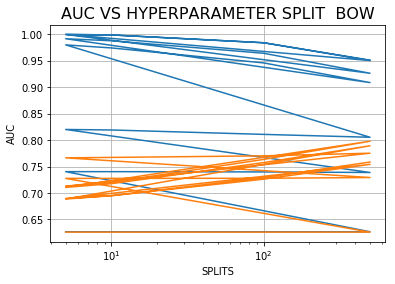



 Split Values :
 [5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500]

 Train AUC for each alpha value is :
  [0.62665 0.62665 0.62665 0.62665 0.74036 0.74036 0.73985 0.73879 0.82014
 0.81919 0.81085 0.80542 0.98017 0.97437 0.94604 0.90883 0.99179 0.98792
 0.9643  0.92651 0.9999  0.99898 0.98412 0.95052 0.9999  0.99897 0.98425
 0.95127]

 CV AUC for each alpha value is :
  [0.62599 0.62599 0.62599 0.62599 0.72765 0.72765 0.72783 0.72925 0.76653
 0.76729 0.77026 0.77525 0.7127  0.72021 0.7635  0.79792 0.71057 0.71761
 0.75756 0.78931 0.68854 0.69488 0.72617 0.75414 0.68956 0.69498 0.72902
 0.75855]


In [188]:
plt.plot(alph_split,train_auc_tfidf)
plt.plot(alph_split,cv_auc_tfidf)
plt.xlabel('SPLITS',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER SPLIT  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Split Values :\n", alph_split)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc_tfidf,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc_tfidf,5))

# Observations :

1) We found that optimal value for depth is 50 and min_samples_split is 500 as the cv accuracy is highest for that point.

# Training the model with the best hyper parameter for TFIDF 

In [164]:
om_tfidf = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50 , min_samples_split = 500 )

In [165]:
om_tfidf.fit(c3, y_train1)
ompredictions_tfidf  = om_tfidf.predict(d3)

In [166]:
probs2 = om_tfidf.predict_proba(c3)
probs3 = om_tfidf.predict_proba(d3)
probs2= probs2[:, 1]
probs3 = probs3[:, 1]

# Feature  Importance for TFIDF  and exporting Decision Tree 

In [243]:
features = tf_idf_vect.get_feature_names()

In [247]:
from sklearn.tree import export_graphviz
target = ['negative','positive']
export_graphviz(om_tfidf,out_file='tfidf_dt.dot.',class_names=target,rounded = True, proportion = False,max_depth=3,feature_names=features)

In [168]:
feat_importances = om_tfidf.feature_importances_

In [169]:
len(features)

9723

In [250]:
features.append('zzzzzzzzzzzaaaaaa')

In [171]:
cf = pd.DataFrame({'Word' : features, 'Coefficient' : feat_importances})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 20 IMPORTANT FEATURES  *****')
print('\n')
print(cf_new.head(20))

***** Top 20 IMPORTANT FEATURES  *****


              Word  Coefficient
5710           not     0.135897
3778         great     0.089494
718           best     0.040796
2241     delicious     0.038182
5003          love     0.033816
3698          good     0.026103
6176       perfect     0.025101
5008         loves     0.024190
2443  disappointed     0.024006
2965     excellent     0.015996
5660          nice     0.015340
3139      favorite     0.014419
9582     wonderful     0.013318
4045        highly     0.012381
546            bad     0.012284
2719          easy     0.009321
5465         money     0.009194
8750       thought     0.008516
7175       reviews     0.007863
3237          find     0.007627


# Observations :
1) We found that the top 2 most important features affecting positive class are not and great.

# PERFORMANCE MEASURMENTS FOR TFIDF 

In [172]:
precision_tfidf = precision_score(y_test1, ompredictions_tfidf, pos_label = 1) 
recall_tfidf = recall_score(y_test1, ompredictions_tfidf, pos_label = 1) 
f1score_tfidf = f1_score(y_test1, ompredictions_tfidf, pos_label = 1) 

In [174]:
print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_tfidf))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_tfidf))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_tfidf))


The Test Precision for optimal c for LR (TFIDF) is 0.931866

The Test Recall for optimal c for LR (TFIDF) is  0.718217

The Test F1-Score for optimal c for LR (TFIDF) is  0.811210


# CONFUSION MATRIX (TFIDF)

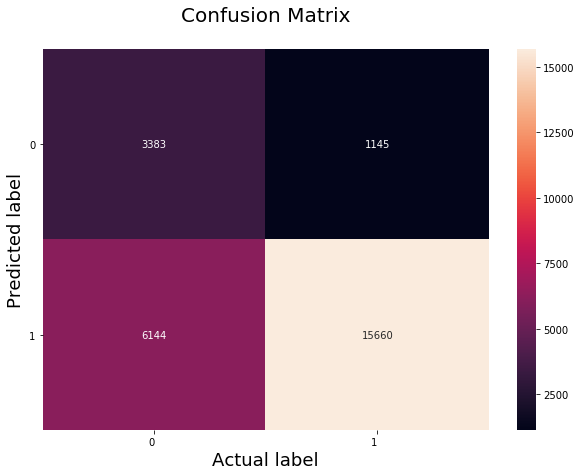

In [175]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_tfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [176]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_tfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TPR))
print("FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FPR))
print("TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TNR))
print("FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FNR))

TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.931866
FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.644904
TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.355096
FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.068134


# ROC CURVE FOR TFIDF 

In [177]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs3)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [178]:
from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

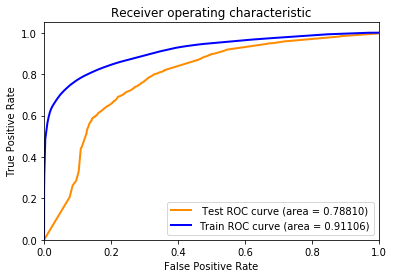

In [180]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.5f)' % roc_auc[0])
plt.plot(fpr1[2], tpr1[2], color='blue',lw=lw, label='Train ROC curve (area = %0.5f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations: 
1) We found that the training score has been good . However the test score has been less. It means that the model is over fitted to some extent 

# Word 2 Vector Data

# Preparaing Training Data for Word to Vector 

In [189]:
i=0
list_of_sentance=[]
for sentance in (X_trainbow['Cleaned Text'].values):
    list_of_sentance.append(sentance.split())

In [190]:
#WORD TO VECTOR

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('fantastic', 0.8406455516815186), ('awesome', 0.8259341716766357), ('good', 0.8041646480560303), ('excellent', 0.7943145632743835), ('terrific', 0.7926111817359924), ('amazing', 0.7851496934890747), ('wonderful', 0.7577135562896729), ('perfect', 0.752568244934082), ('fabulous', 0.6984073519706726), ('decent', 0.6744866371154785)]
[('best', 0.733176589012146), ('greatest', 0.719762921333313), ('tastiest', 0.7155513763427734), ('closest', 0.6296120882034302), ('disgusting', 0.6190059185028076), ('healthiest', 0.6187819242477417), ('experienced', 0.6123749017715454), ('coolest', 0.6008093953132629), ('awful', 0.5906195044517517), ('neapolitan', 0.5890594720840454)]
number of words that occured minimum 5 times  14706
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'rega

In [191]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [01:28<00:00, 690.56it/s]


61441
50


In [192]:
sent_vectors[1]

array([ 0.56022235,  0.67879919, -1.16433695,  0.65188279, -0.21017857,
       -0.23444822, -0.53972821, -1.61046622,  0.19608753, -0.25899484,
        0.04205897,  0.60934081,  0.15788466, -0.29382586,  0.3356308 ,
       -0.52329437, -0.27323416,  0.08312617, -0.88036611,  0.7756978 ,
        0.17861451, -0.04143068, -0.14238001, -0.43226893,  0.37092679,
        0.6208309 ,  1.28321907,  0.04711953, -0.05883861,  0.11775111,
        0.2887365 ,  0.1064998 ,  0.4384588 , -0.48808138,  0.04436555,
        0.19986581,  0.19658527,  0.94421775, -0.1201418 ,  1.26456587,
        0.42490968,  0.31975452,  0.30604115, -0.31224488,  0.63765167,
       -0.0106173 ,  0.56775195, -0.06896764,  0.65739828, -0.41883424])

# Preparing Test Data for Word to Vector 

In [193]:
X_test1.head(4)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181
61444,westie like picture package loves treats perfe...,162


In [194]:
i=0
list_of_sentance1=[]
for sentance in (X_test1['Cleaned Text'].values):
    list_of_sentance1.append(sentance.split())

In [195]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model1=Word2Vec(list_of_sentance1,min_count=5,size=50, workers=4)
    print(w2v_model1.wv.most_similar('great'))
    print('='*50)
    print(w2v_model1.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model1.wv.most_similar('great'))
        print(w2v_model1.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

[('awesome', 0.8254234194755554), ('excellent', 0.8242385983467102), ('good', 0.7897971868515015), ('fantastic', 0.7889764308929443), ('wonderful', 0.7711959481239319), ('amazing', 0.7454652786254883), ('perfect', 0.7004916667938232), ('decent', 0.694219708442688), ('nice', 0.6861531734466553), ('terrific', 0.6521133184432983)]
[('best', 0.7830518484115601), ('greatest', 0.7777789831161499), ('closest', 0.7717968225479126), ('nastiest', 0.7655762434005737), ('ever', 0.7230478525161743), ('tastiest', 0.7198038697242737), ('disgusting', 0.6892082691192627), ('hottest', 0.6884726881980896), ('beats', 0.6878105401992798), ('superior', 0.6872898936271667)]
number of words that occured minimum 5 times  9573
sample words  ['used', 'treat', 'training', 'reward', 'dog', 'loves', 'easy', 'break', 'smaller', 'pieces', 'buy', 'much', 'fun', 'watching', 'puppies', 'asking', 'chicken', 'treats', 'go', 'crazy', 'show', 'blue', 'package', 'small', 'eat', 'not', 'bad', 'smell', 'recommend', 'happy', 'l

In [196]:
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:26<00:00, 981.69it/s]


26332
50


In [197]:
e3 = sent_vectors
f3 = sent_vectors1

In [198]:
len(y_test1)

26332

In [199]:
e3 = preprocessing.normalize(e3)
e4 = sparse.csr_matrix(X_train1['Length'].values)
e4 = preprocessing.normalize(e4)
e5 = sparse.hstack([e3, e4.T])

In [200]:
f3 = preprocessing.normalize(f3)
f4 = sparse.csr_matrix(X_test1['Length'].values)
f4 = preprocessing.normalize(f4)
f5 = sparse.hstack([f3, f4.T])

# Applying Decision Tree on Word to VECTOR 

In [208]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model_w2v = GridSearchCV(DecisionTreeClassifier(max_features="log2",class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model_w2v.fit(e5, y_train1)
print(model_w2v.best_estimator_)
print(model_w2v.score(f5, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6566681162985621


In [209]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model_w2v1 = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model_w2v1.fit(e5, y_train1)
print(model_w2v1.best_estimator_)
print(model_w2v1.score(f5, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.5923836419209885


# Observations:

1) Both the above models have very less frequency . Surprisingly when we consider the log of features only the accuracy is high. 

In [216]:
model3 = model_w2v

In [217]:
model_w2v.cv_results_

{'mean_fit_time': array([0.09014406, 0.09032226, 0.09253793, 0.0874784 , 0.22807107,
        0.23079228, 0.23946481, 0.21244936, 0.61974654, 0.60959082,
        0.58819976, 0.42781701, 1.14950814, 1.10482087, 0.90074325,
        0.47751718, 1.15530291, 1.10393691, 0.90082531, 0.49071083,
        1.19088373, 1.13182101, 0.89601364, 0.49658022, 1.22367826,
        1.15857687, 0.8935699 , 0.50690885]),
 'std_fit_time': array([0.00608462, 0.01254362, 0.00812381, 0.00765249, 0.00765228,
        0.00847297, 0.01533399, 0.00765321, 0.02274793, 0.01626625,
        0.01521377, 0.00784872, 0.03355539, 0.03161787, 0.03846654,
        0.01627087, 0.03370975, 0.02757575, 0.02799729, 0.0112693 ,
        0.04492254, 0.05387487, 0.03493974, 0.01819977, 0.06924667,
        0.02345011, 0.02295924, 0.03388925]),
 'mean_score_time': array([0.00937328, 0.0126193 , 0.01509137, 0.00937309, 0.01249776,
        0.01475902, 0.01110325, 0.01562243, 0.01562853, 0.0123517 ,
        0.01506977, 0.01248875, 0.015594

In [218]:
train_auc_w2v = model3.cv_results_['mean_train_score']
cv_auc_w2v = model3.cv_results_['mean_test_score']

In [219]:
alph_depth = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50,100,100,100,100,500,500,500,500,1000,1000,1000,1000]
alph_split = [5,10,100,500]*7

In [220]:
train_auc_w2v

array([0.61528304, 0.61310825, 0.58141178, 0.61068417, 0.77735605,
       0.77459569, 0.75880431, 0.76837219, 0.88840428, 0.88497774,
       0.87333974, 0.82857391, 0.99915988, 0.99431257, 0.91425401,
       0.84163354, 0.99916123, 0.99403089, 0.91428872, 0.83774625,
       0.99914993, 0.99423663, 0.91128143, 0.83687438, 0.99918352,
       0.99423439, 0.91233328, 0.83512133])

In [221]:
cv_auc_w2v

array([0.60959541, 0.60358657, 0.57268929, 0.60170863, 0.76440561,
       0.75711031, 0.74017231, 0.74915389, 0.7787401 , 0.76846661,
       0.78595811, 0.77615454, 0.650567  , 0.67097428, 0.76704517,
       0.79231155, 0.64759531, 0.66961544, 0.76656415, 0.78402142,
       0.64921289, 0.66896228, 0.76388742, 0.79071436, 0.64901665,
       0.67022125, 0.76481953, 0.78175358])

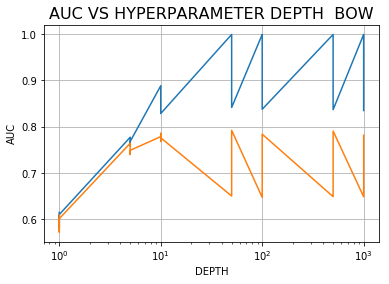



 Depth Values :
 [1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10, 50, 50, 50, 50, 100, 100, 100, 100, 500, 500, 500, 500, 1000, 1000, 1000, 1000]

 Train AUC for each alpha value is :
  [0.61528 0.61311 0.58141 0.61068 0.77736 0.7746  0.7588  0.76837 0.8884
 0.88498 0.87334 0.82857 0.99916 0.99431 0.91425 0.84163 0.99916 0.99403
 0.91429 0.83775 0.99915 0.99424 0.91128 0.83687 0.99918 0.99423 0.91233
 0.83512]

 CV AUC for each alpha value is :
  [0.6096  0.60359 0.57269 0.60171 0.76441 0.75711 0.74017 0.74915 0.77874
 0.76847 0.78596 0.77615 0.65057 0.67097 0.76705 0.79231 0.6476  0.66962
 0.76656 0.78402 0.64921 0.66896 0.76389 0.79071 0.64902 0.67022 0.76482
 0.78175]


In [222]:
plt.plot(alph_depth,train_auc_w2v)
plt.plot(alph_depth,cv_auc_w2v)
plt.xlabel('DEPTH',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER DEPTH  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Depth Values :\n", alph_depth)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc_w2v,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc_w2v,5))

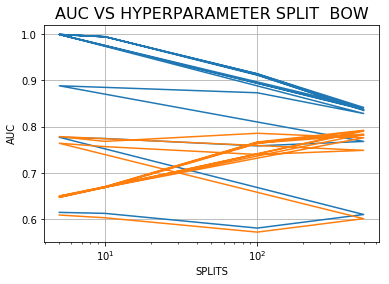



 Split Values :
 [5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500, 5, 10, 100, 500]

 Train AUC for each alpha value is :
  [0.61528 0.61311 0.58141 0.61068 0.77736 0.7746  0.7588  0.76837 0.8884
 0.88498 0.87334 0.82857 0.99916 0.99431 0.91425 0.84163 0.99916 0.99403
 0.91429 0.83775 0.99915 0.99424 0.91128 0.83687 0.99918 0.99423 0.91233
 0.83512]

 CV AUC for each alpha value is :
  [0.6096  0.60359 0.57269 0.60171 0.76441 0.75711 0.74017 0.74915 0.77874
 0.76847 0.78596 0.77615 0.65057 0.67097 0.76705 0.79231 0.6476  0.66962
 0.76656 0.78402 0.64921 0.66896 0.76389 0.79071 0.64902 0.67022 0.76482
 0.78175]


In [224]:
plt.plot(alph_split,train_auc_w2v)
plt.plot(alph_split,cv_auc_w2v)
plt.xlabel('SPLITS',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER SPLIT  BOW',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Split Values :\n", alph_split)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc_w2v,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc_w2v,5))

In [226]:
max(cv_auc_w2v)

0.7923115528602512

# Observations:

1) Optimal number of splits = 500 and max_depth = 50 as the cv_auc is high at that point

# Running the model with the optimal hyperparameter 

In [227]:
om_w2v = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 50 , min_samples_split = 500 )
om_w2v.fit(e5, y_train1)
ompredictions_w2v  = om_w2v.predict(f5)
probs4 = om_w2v.predict_proba(e5)
probs5 = om_w2v.predict_proba(f5)
probs4= probs4[:, 1]
probs5 = probs5[:, 1]

# PERFORMANCE MEASURMENTS FOR w2v Decision Tree

In [228]:
precision_w2v = precision_score(y_test1, ompredictions_w2v, pos_label = 1) 
recall_w2v = recall_score(y_test1, ompredictions_w2v, pos_label = 1) 
f1score_w2v = f1_score(y_test1, ompredictions_w2v, pos_label = 1) 

print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_w2v))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_w2v))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_w2v))


The Test Precision for optimal c for LR (TFIDF) is 0.850684

The Test Recall for optimal c for LR (TFIDF) is  0.837966

The Test F1-Score for optimal c for LR (TFIDF) is  0.844277


Text(0.5,1,'Confusion Matrix\n')

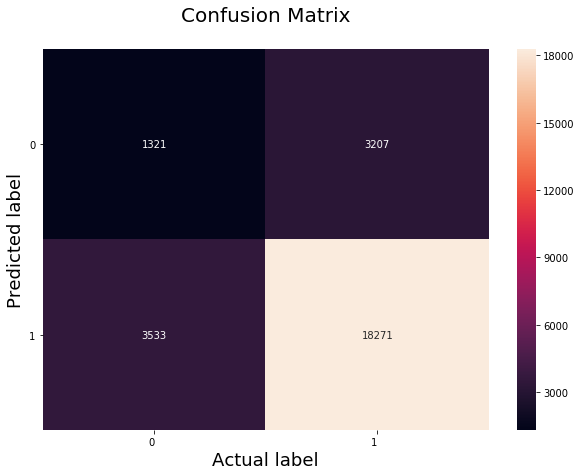

In [229]:
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2v), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [230]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2v).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Logistic Regression  (TFIDF) for optimal alpha   is :  %f" % (TPR))
print("FPR of the Logistic Regression (TFIDF) for optimal  alpha  is :  %f" % (FPR))
print("TNR of the Logistic Regression (TFIDF) for optimal alpha  is :  %f" % (TNR))
print("FNR of the Logistic Regression (TFIDF) for optimal alpha  is :  %f" % (FNR))

TPR of the Logistic Regression  (TFIDF) for optimal alpha   is :  0.850684
FPR of the Logistic Regression (TFIDF) for optimal  alpha  is :  0.727853
TNR of the Logistic Regression (TFIDF) for optimal alpha  is :  0.272147
FNR of the Logistic Regression (TFIDF) for optimal alpha  is :  0.149316


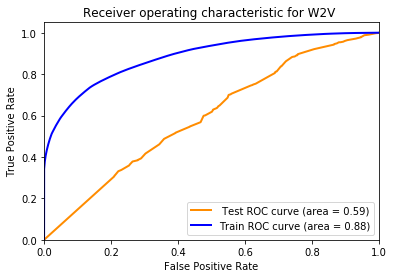

In [231]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs5)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs4)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic for W2V ')
plt.show()

# Observations :

1) Word 2 vECTOR HAS NOT PERFORMED THAT EFFICIENTLY WHEN COMPARED TO BOW or TFIDF.

2) Test Acuuracy is very less when compared to train accuracy. Hence Overfitting would have been the issue here.

# TFIDF AVERGE WORD TO VECTOR 

# Preparing Training Data for TFIDF-AVG W2V

In [248]:
model = TfidfVectorizer()
model.fit_transform(X_trainbow['Cleaned Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [203]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [14:11<00:00, 72.17it/s]


# Preparing Test Data for TFIDF- AVG W2V

In [204]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat:
            vec = w2v_model1.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [17:52<00:00, 24.54it/s]


In [205]:
g3 = tfidf_sent_vectors
h3 = tfidf_sent_vectors1

In [206]:
g3 = preprocessing.normalize(g3)
h3 = preprocessing.normalize(h3)

# DECISION TREE ON TFIDF - AVG W2V 

In [232]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model1 = GridSearchCV(DecisionTreeClassifier(max_features="log2",class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model1.fit(g3, y_train1)
print(model1.best_estimator_)
print(model1.score(h3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.5848606783418351


In [233]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'min_samples_split' : [5, 10, 100, 500]}]
model2 = GridSearchCV(DecisionTreeClassifier(class_weight = 'balanced'), tree_para, scoring = 'roc_auc', cv=5, return_train_score= True)
model2.fit(g3, y_train1)
print(model2.best_estimator_)
print(model2.score(h3, y_test1))

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6099152441394033


# Running the model with the optimal depth and split

In [234]:
om_w2vtfidf = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 10 , min_samples_split = 500 )
om_w2vtfidf.fit(g3, y_train1)
ompredictions_w2vtfidf  = om_w2vtfidf.predict(h3)

In [235]:
probs6 = om_w2vtfidf.predict_proba(g3)
probs7 = om_w2vtfidf.predict_proba(h3)
probs6= probs6[:, 1]
probs7 = probs7[:, 1]

In [236]:
precision_w2vtfidf = precision_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
recall_w2vtfidf = recall_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
f1score_w2vtfidf = f1_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 

In [237]:
print('\nThe Test Precision for optimal c for LR (TFIDF) is %f' % (precision_w2vtfidf))
print('\nThe Test Recall for optimal c for LR (TFIDF) is  %f' % (recall_w2vtfidf))
print('\nThe Test F1-Score for optimal c for LR (TFIDF) is  %f' % (f1score_w2vtfidf))


The Test Precision for optimal c for LR (TFIDF) is 0.854571

The Test Recall for optimal c for LR (TFIDF) is  0.746790

The Test F1-Score for optimal c for LR (TFIDF) is  0.797053


Text(0.5,1,'Confusion Matrix\n')

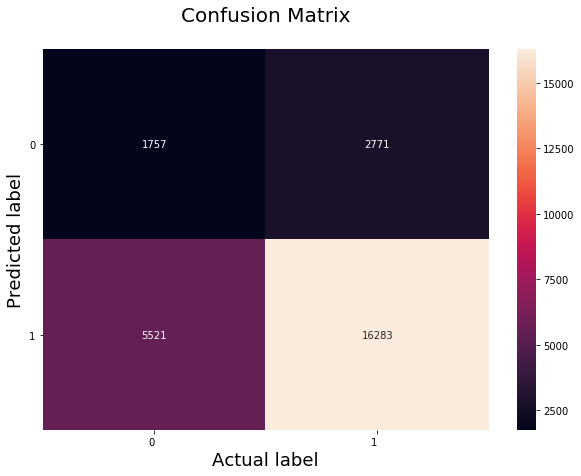

In [238]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2vtfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [239]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2vtfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TPR))
print("FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FPR))
print("TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (TNR))
print("FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  %f" % (FNR))

TPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.854571
FPR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.758588
TNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.241412
FNR of the Multinomial naive Bayes classifier (TFIDF) for alpha  is :  0.145429


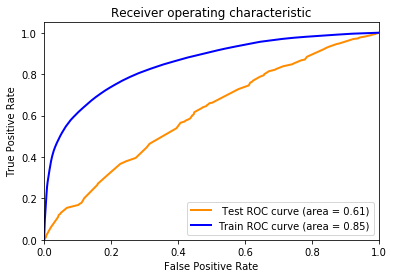

In [241]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs7)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs6)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 

1) Both Training Accuracy and Test acccuracy has been very low in TFIDF- AVG W2V. 
  The reason might be the case that I did not take feature engineering for this vectoriser and the model may be over fitted.


# Conclusions

In [242]:
res = pd.DataFrame()

In [254]:
model_names = ["BOW","BOW","TF-IDF","TF-IDF","W2V","W2V", "TF-IDF AVGW2V" , "TF-IDF AVGW2V"]
max_depth = [1000,50,1000,1000,50,10,10,10]
min_samples_split = [500]*8
s1 = "YES"
s2 = "NO"
Feature_Engineering = [s1,s1,s1,s1,s1,s1,s2,s2]
AUC = [0.6838,0.8006,0.6988,0.7890,0.6567,0.5924,0.5849,0.6099]

In [258]:
max_features = ["log(N)", "N"]*4

In [259]:
res['Vectorizer'] = model_names
res['Max_Features'] = max_features
res['Maximum Depth'] =  max_depth 
res['Minimum Samples Split'] = min_samples_split 
res['Feature Engineering'] = Feature_Engineering  
res['AUC'] = AUC

In [260]:
res

,Vectorizer,Max_Features,Maximum Depth,Minimum Samples Split,Feature Engineering,AUC
0,BOW,log(N),1000,500,YES,0.6838
1,BOW,N,50,500,YES,0.8006
2,TF-IDF,log(N),1000,500,YES,0.6988
3,TF-IDF,N,1000,500,YES,0.7890
4,W2V,log(N),50,500,YES,0.6567
5,W2V,N,10,500,YES,0.5924
6,TF-IDF AVGW2V,log(N),10,500,NO,0.5849
7,TF-IDF AVGW2V,N,10,500,NO,0.6099


In [262]:
import tabulatehelper as th

# DISPLAYING THE RESULTS IN TABULAR FORMAT 

In [264]:
print(th.md_table(res, formats={-1: 'c'}))

| Vectorizer    | Max_Features   |   Maximum Depth |   Minimum Samples Split | Feature Engineering   |    AUC |
|:--------------|:---------------|----------------:|------------------------:|:----------------------|:------:|
| BOW           | log(N)         |            1000 |                     500 | YES                   | 0.6838 |
| BOW           | N              |              50 |                     500 | YES                   | 0.8006 |
| TF-IDF        | log(N)         |            1000 |                     500 | YES                   | 0.6988 |
| TF-IDF        | N              |            1000 |                     500 | YES                   | 0.789  |
| W2V           | log(N)         |              50 |                     500 | YES                   | 0.6567 |
| W2V           | N              |              10 |                     500 | YES                   | 0.5924 |
| TF-IDF AVGW2V | log(N)         |              10 |                     500 | NO                    | 0

# Final Observations :


1) The best models have come through BOW and TFIDF. In TFIDF the AUC has been slightly lower when compared to BOW. 

2) IN THE CASE OF BAG OF WORDS, TFIDF considering N features  PERFORMED significantly  BETTER WHEN COMPARED TO Log(N) features.

3) IN THE CASE OF AVGW2V  considering N features efficiency is less when compared to Log(N) features.

5) IN THE CASE OF TFIDF- AVG W2V, I HAVE NOT USED FEATURE ENGINEERING. considering N features  PERFORMED significantly  BETTER WHEN COMPARED TO Log(N) features.

6) As suggested I have added length of preprocessed reviews as one more feature which has been contributed for more accuracy. 
   However if i would have used more features like length of common words or something else, the results would have been 
   different( my assumption)

7) I have visualised the tree for BOW and TFIDF. As it is not clear in the jupyter notebook, I have exported.


8) Overall, the best model for the decision tree classifier is BOW with 0.80 AUC.

# References 

I have referred many links. However part of my code has been inspired from the following links 

1) Applied AI Course  - https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/

2) SKLEARN 

3) STACK OVERFLOW  - MANY 